## Advanced Lane Finding

### Project 3 of the Udacity Self-Driving Car Nanodegree program

Check [**Rubric**](https://review.udacity.com/#!/rubrics/571/view) for passing prerequisites

In [2]:
# import needed libraries
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# %matplotlib qt

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [ ]:
# %% Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
# read calibration images from folder
images = glob.glob('camera_cal/calibration*.jpg')

# object points in x and y direction
nx = 9
ny = 6

# prepare holders for object point and image points
objpoints = [] # 3D in real world space
imgpoints = [] # 2D points in image plane

# generate coodinates for object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
#         print('Points found for: ',fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
#         #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
else:
    # save image size
    img_size = gray.shape[::-1]
    plt.imshow(img)
    plt.title('Sample Calibration Image')

# Do camera calibration using object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   img_size[:2],None,None)
np.savetxt('cam_mtx.txt', mtx)
np.savetxt('cam_dist.txt', dist)

Apply a distortion correction to raw images

In [ ]:
# %% Apply a distortion correction to raw images

# load sample image 1
img1 = mpimg.imread('camera_cal/calibration1.jpg')

# load sample image 2
img2 = mpimg.imread('test_images/test1.jpg')

# undistort images
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
undist2 = cv2.undistort(img2, mtx, dist, None, mtx)

# display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) # 
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist1)
ax2.set_title('Undistorted Image', fontsize=30)
# f.savefig('output_images/undistort_result1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) # 
f.tight_layout()

ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist2)
ax2.set_title('Undistorted Image', fontsize=30)
# f.savefig('output_images/undistort_result2.jpg')

Use colour transforms, gradient, etc, to create a threshold binary image

In [ ]:
# sample visualization of how lane lines are displayed in colour channels
img = mpimg.imread('test_images/test4.jpg')
# for rgb colour space
r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(r_channel, cmap='gray')
ax1.set_title('R Channel', fontsize=20)
ax2.imshow(g_channel, cmap='gray')
ax2.set_title('G Channel', fontsize=20)
ax3.imshow(b_channel, cmap='gray')
ax3.set_title('B Channel', fontsize=20)
# f.savefig('output_images/rgb_colourspace')

# for hls colour space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(l_channel, cmap='gray')
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('S Channel', fontsize=20)
# f.savefig('output_images/hls_colourspace')

In [272]:
# %% Use colour transforms, gradient, etc, to create a threshold binary image
# pipeline to combine colour thresholding and gradient thresholding on image
def thresh_bin_im(img, s_thresh=(120, 255), sxl_thresh=(20, 100), sxr_thresh=(20, 100), kernel=5):
    """
    Return the colour thresholds binary for L, S and R channels in an image
    img: RGB image
    s_thresh: S channel threshold
    sxl_thresh: sobel x threshold for L channel
    sxr_thresh: sobel x threshold for R channel
    """
    
    # Convert to HSL color space and separate L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # from observation, R channel also gives a good result on lane lines
    r_channel = img[:,:,0]

    # Sobel x on L channel
    l_channel[(s_channel >= 120) & (s_channel <= 255)] = 1 # hard thresholding based on observation
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=kernel) # derivative
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sxl = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))

    # Threshold x gradient
    sxlbinary = np.zeros_like(scaled_sxl)
    sxlbinary[(scaled_sxl >= sxl_thresh[0]) & (scaled_sxl <= sxl_thresh[1])] = 1

    # sobel x on R channel
    sobelx_r = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=kernel)
    abs_sobelx_r = np.absolute(sobelx_r)
    scaled_sxr = np.uint8(255*abs_sobelx_r/np.max(abs_sobelx_r))

    # Threshold x gradient
    sxrbinary = np.zeros_like(scaled_sxr)
    sxrbinary[(scaled_sxr >= sxr_thresh[0]) & (scaled_sxr <= sxr_thresh[1])] = 1

    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # empty channel
    empty = np.zeros_like(s_channel)
    
    # Stack each channel
    color_binary = np.dstack((s_binary, sxlbinary, empty))

    return color_binary

def bin_image(image):
    """
    convert colour binary image into a single channel binary image
    image: array with 3 channels
    return binary image with 1 channel which is a bitwise or operation of the original colour channels
    """
    binary = np.zeros_like(image[:,:,1])
    binary[(image[:,:,0] == 1) | (image[:,:,1]==1) |(image[:,:,2]==1)] = 1
    return binary

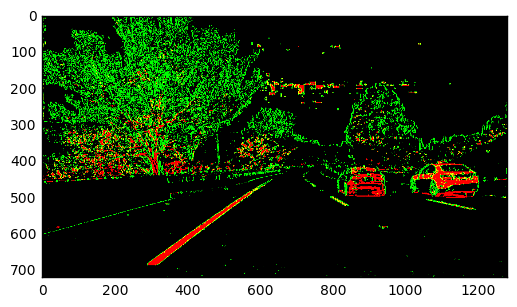

In [281]:
img = mpimg.imread('test_images/test6.jpg')
color_binary = thresh_bin_im(img, s_thresh=(120, 255), sxl_thresh=(20, 255), sxr_thresh=(120, 255), kernel=3)
plt.imshow(color_binary)
# plt.title('colour transform and gradient binary image example')
# plt.savefig('output_images/colour transform and gradient bin image.jpg')

In [ ]:
image = mpimg.imread('test_images/test6.jpg')
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]


h_channel[(h_channel >= 34) & (h_channel <= 33)]=1
l_channel[(l_channel >= 150) & (l_channel <= 255)]=1
s_channel[(s_channel >= 120) & (s_channel <= 255)]=1

# show_im = np.dstack((h_channel, l_channel, s_channel))

# h_channel = cv2.Canny(h_channel, 100, 200)

plt.imshow(l_channel, cmap='gray')
# Threshold S color channel
# s_binary = np.zeros_like(s_channel)
# s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

In [ ]:
# convert to 1 channel binary
binary = bin_image(color_binary)

plt.imshow(binary, cmap='gray')
# plt.title('Binary image from colour binary image sample')
# plt.savefig('output_images/full binary image.jpg')

In [ ]:
# region of interest function
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

Apply a perspective transform to rectify binary image ("birds-eye view")

In [ ]:
# %% Apply a perspective transform to rectify binary image ("birds-eye view")
# %matplotlib qt

# load a straight line image to determine road plane
straight_lines_im = mpimg.imread('test_images/straight_lines1.jpg')

# apply colour transformation
straight_lines_bin = thresh_bin_im(img, s_thresh=(170, 255), sxl_thresh=(20, 100), sxr_thresh=(20, 100), kernel=5)

straight_lines_bin = straight_lines_bin.astype(np.int8) # without this line, the output is a total black image

# apply roi to straight image
# %matplotlib qt # to show interactive image display
imshape = straight_lines_bin.shape[:2]

## define roi for image
mask_height = imshape[0]/2 + 90
vertices = np.array([[(0,imshape[0]),(imshape[1]/2 - 50, mask_height), 
                      (imshape[1]/2 + 50, mask_height), (imshape[1],imshape[0])]], dtype=np.int32)
##

roi_image = region_of_interest(straight_lines_bin, vertices)
roi_image = bin_image(roi_image)
plt.imshow(roi_image, cmap='gray')
# print roi_image.shape

In [ ]:
# Compute the perspective transform, M, given source and destination points:

# TODO: need better routine to extract source points

# here we manually pick points on the image that corresponds to the plane of the road in other to use it to warp the image to a bird's eye view
src_points = np.float32([[275,673],
                         [595,449],
                         [686,449],
                         [1035,673]])
dst_points = np.float32([[275,673],
                         [275,0],
                         [1035,0],
                         [1035,673]])
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

np.savetxt('M_mat.txt', M)
np.savetxt('Minv_mat.txt', Minv)

# we could use opencv's find contours to effectively find points on the road plane
# im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def transform_n_warp(image, M):
    """
    apply transforms to image and warp the image according to transformation matrix
    image: image to be transformed
    M: transformation matrix
    """
    # image size
    img_size = image.shape[:2][::-1]
    
    # warp image
    image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    # convert to coloured binary image
    image = thresh_bin_im(image, s_thresh=(170, 255), sxl_thresh=(20, 100), sxr_thresh=(20, 100), kernel=3)
    
    # convert to 1 channel binary image
    image = bin_image(image)
    
    return image

In [ ]:
# test pipeline on an image
test_im = mpimg.imread('test_images/test4.jpg')
plt.imshow(test_im)

In [ ]:
warped = transform_n_warp(test_im, M)

plt.imshow(warped, cmap='gray')
# plt.savefig('output_images/test4_warped.jpg')

Detect lane pixels and fit to find the lane boundary

In [ ]:
# %% Detect lane pixels and fit to find the lane boundary
# we first take a histogram along all the columns in the lower half of the image
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.title('Warped Image lower half column histogram')
# plt.savefig('output_images/warped_histogram.jpg')

In [ ]:
## implement sliding windows and fit a polynomial

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))#*255

# convert image to integer arrays
out_img = out_img.astype(np.int8)

plt.imshow(out_img)

In [ ]:
# find lane function, with sliding window approach
def find_lane(warped, new_line=True):
    """
    return image with lane lines using sliding window approach
    warped: image in bird's eye view
    """
    if new_line:
        # we first take a histogram along all the columns in the lower half of the image
        histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Number of sliding windows
        nwindows = 9

        # Height of windows
        window_height = np.int(warped.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 50

        # Set minimum number of pixels found to recenter window
        minpix = 100

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # change the colour of nonzero pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
    
    return out_img

In [ ]:
laned = find_lane(warped)
plt.imshow(laned)

In [ ]:
# Skip the sliding windows step once you know where the lines are

test_im_2 = mpimg.imread('test_images/test1.jpg')
binary_warped = transform_n_warp(test_im_2, M)

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
window_img = np.zeros_like(out_img)

In [ ]:
# # convert image to integer arrays
# out_img = out_img.astype(np.int8)
# window_img = window_img.astype(np.int8)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]

In [ ]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

# out_img = out_img.astype(np.int8)
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

Determine the curvature of the lane and vehicle position with respect to center

In [ ]:
# %% Determine the curvature of the lane and vehicle position with respect to center

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [ ]:
## So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# # Fit a second order polynomial to each
# left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [ ]:
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

Warp the detected lane boundaries back onto the original image

In [ ]:
# %% Warp the detected lane boundaries back onto the original image
# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(result, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(result, Minv, (img_size[0], img_size[1])) 

newwarp = np.uint8(newwarp)

# Combine the result with the original image
final = cv2.addWeighted(test_im_2, 1, newwarp, 0.5, 0)
plt.imshow(final)

Output visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position

In [ ]:
img_size[1]

In [ ]:
# %% Output visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position

# calculate lane midpoint
# left line intercept on x axis
left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]

# right line intercept on x axis
right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]

lane_mid = (left_intcpt + right_intcpt)/2.0

car_off = lane_mid - img_size[0]/2.0

# convert to meters
car_off *= xm_per_pix


# create display texts on image
font = cv2.FONT_HERSHEY_COMPLEX
curve_disp_txt = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2)) + 'm' 

off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'

cv2.putText(final, curve_disp_txt, (30, 60), font, 1, (0,0,0), 2)
cv2.putText(final, off_disp_txt, (30, 90), font, 1, (0,0,0), 2)

plt.imshow(final)


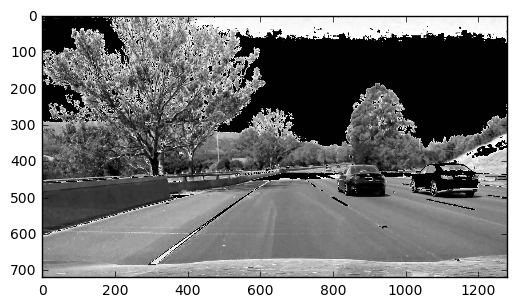

In [282]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # flag for new line
        self.new_line = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.ploty = []
        
        # parameters
        self.dst = np.loadtxt('cam_dist.txt')
        self.mtx = np.loadtxt('cam_mtx.txt')
        self.src_points = np.float32([[275,673],
                         [595,449],
                         [686,449],
                         [1035,673]])
        self.dst_points = np.float32([[275,673],
                                 [275,0],
                                 [1035,0],
                                 [1035,673]])
        self.M = np.loadtxt('M_mat.txt')
        self.Minv = np.loadtxt('Minv_mat.txt')
        
        # windows
        # Set the width of the windows +/- margin
        self.margin = 50

        # Set minimum number of pixels found to recenter window
        self.minpix = 100
        
        # Conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        
    def thresh_bin_im(self, img, s_thresh=(170, 255), sxl_thresh=(20, 100), sxr_thresh=(20, 100), kernel=5):
        """
        Return the colour thresholds binary for L, S and R channels in an image
        img: RGB image
        s_thresh: S channel threshold
        sxl_thresh: sobel x threshold for L channel
        sxr_thresh: sobel x threshold for R channel
        """

        # Convert to HSL color space and separate L and S channels
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]

        # from observation, R channel also gives a good result on lane lines
        r_channel = img[:,:,0]

        # Sobel x on L channel
        l_channel[(s_channel >= 120) & (s_channel <= 255)] = 1 # hard thresholding based on observation
        sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=kernel) # derivative
        abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sxl = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))

        # Threshold x gradient
        sxlbinary = np.zeros_like(scaled_sxl)
        sxlbinary[(scaled_sxl >= sxl_thresh[0]) & (scaled_sxl <= sxl_thresh[1])] = 1

        # sobel x on R channel
        sobelx_r = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=kernel)
        abs_sobelx_r = np.absolute(sobelx_r)
        scaled_sxr = np.uint8(255*abs_sobelx_r/np.max(abs_sobelx_r))

        # Threshold x gradient
        sxrbinary = np.zeros_like(scaled_sxr)
        sxrbinary[(scaled_sxr >= sxr_thresh[0]) & (scaled_sxr <= sxr_thresh[1])] = 1

        # Threshold S color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        # empty channel
        empty = np.zeros_like(s_channel)

        # Stack each channel
        color_binary = np.dstack((s_binary, sxlbinary, empty))

        return color_binary
    
    def bin_image(self, image):
        """
        convert colour binary image into a single channel binary image
        image: array with 3 channels
        return binary image with 1 channel which is a bitwise or operation of the original colour channels
        """
        binary = np.zeros_like(image[:,:,1])
        binary[(image[:,:,0] == 1) | (image[:,:,1]==1) |(image[:,:,2]==1)] = 1
        return binary
    
    def transform_n_warp(self, image, M):
        """
        apply transforms to image and warp the image according to transformation matrix
        image: image to be transformed
        M: transformation matrix
        """
        # image size
        img_size = image.shape[:2][::-1]

        # warp image
        image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

        # convert to coloured binary image
        image = self.thresh_bin_im(image, s_thresh=(170, 255), sxl_thresh=(20, 100), sxr_thresh=(20, 100), kernel=3)

        # convert to 1 channel binary image
        image = self.bin_image(image)

        return image
    def update_fit(self, left_fit, right_fit, patience=6):
        """
        update the fit values for n iterations
        """
        self.current_fit = [left_fit, right_fit]
        self.recent_xfitted.append(self.current_fit)
        if len(self.recent_xfitted) > patience:
            self.recent_xfitted.pop(0)
        
        # calculate best fit, mean of last n iterations determined by patience
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        
        return self.best_fit
        
    
    # find lane function, with sliding window approach
    def find_lane(self, warped):
        """
        return image with lane lines using sliding window approach
        warped: image in bird's eye view
        """
        # check if there is a previous line
#         if self.detected:
#             self.new_line = False

        # Set the width of the windows +/- margin
        margin = self.margin

        # Set minimum number of pixels found to recenter window
        minpix = self.minpix
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped)).astype(np.int8)#*255
        window_img = np.zeros_like(out_img)
        
        if self.new_line:
            # we first take a histogram along all the columns in the lower half of the image
            histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Number of sliding windows
            nwindows = 9

            # Height of windows
            window_height = np.int(warped.shape[0]/nwindows)

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base


            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped.shape[0] - (window+1)*window_height
                win_y_high = warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin


#                 # Draw the windows on the visualization image (not necessary here)
#                 cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
#                 cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]


                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            self.new_line = False
            
        else:
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            left_fit, right_fit = self.best_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # update global left and right fits
        left_fit, right_fit = self.update_fit(left_fit, right_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        
        # save ploty
        self.ploty = ploty
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # change the colour of nonzero pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Define y-value where we want radius of curvature
        # We choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        
#         left_fit, right_fit = self.best_fit
#         left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#         right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, left_fitx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, right_fitx*self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        # out_img = out_img.astype(np.int8)
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
        
        # %% Warp the detected lane boundaries back onto the original image
        # # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(result, np.int_([pts]), (0,255, 0))
        

        return result, left_curverad, right_curverad

    def pipeline(self, frame):
        """ 
        perform all advanced lane finding process on frame        
        and return processed frame
        """
        # smooth the image using gaussian blur
        frame = cv2.medianBlur(frame,3)
        
        # undistort frame
        frame = cv2.undistort(frame, self.mtx, self.dst, None, self.mtx)
        
        
        
        original_frame = np.copy(frame)
        
        # transform image to bird's eye view
        frame = self.transform_n_warp(frame, self.M)
        
        # find lane lines 
        # Check that there is new line
        # Then check that new line detections makes sense, 
        # i.e., expected curvature, separation, and parallel.
        frame, left_curverad, right_curverad = self.find_lane(frame)
        
        print abs(left_curverad - right_curverad)
        
        img_size = (frame.shape[:2][0], frame.shape[:2][1])
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(frame.astype(np.float32), self.Minv, img_size[::-1]) 
        newwarp = np.uint8(newwarp)

        # Combine the result with the original image
        frame = cv2.addWeighted(original_frame, 1, newwarp, 0.5, 0)
        
        # display visuals on frame
        
        # return processed frame
        ret_frame = frame
        return ret_frame.astype(np.uint8)

664.700251094


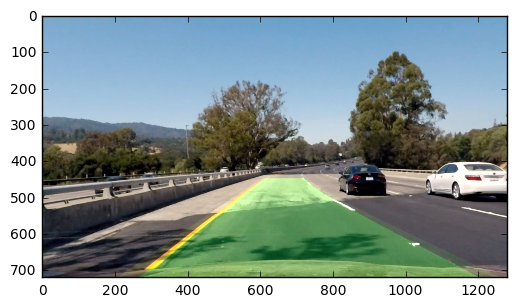

In [284]:
# process output file. To test Line Class

frame_line = Line()
image = mpimg.imread('test_images/test4.jpg')
out = frame_line.pipeline(image)
# print out.dtype
plt.imshow(out, cmap='gray')

2032.69014587


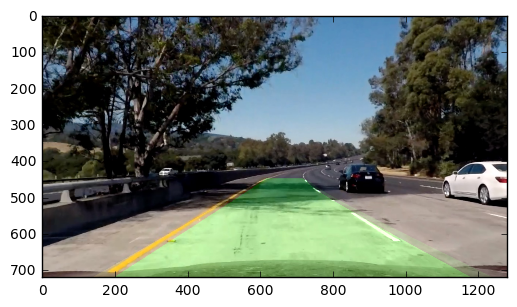

In [285]:
# process output file. iteration 2
image = mpimg.imread('test_images/test5.jpg')
out = frame_line.pipeline(image)
plt.imshow(out, cmap='gray')

4437.7069791
uint8


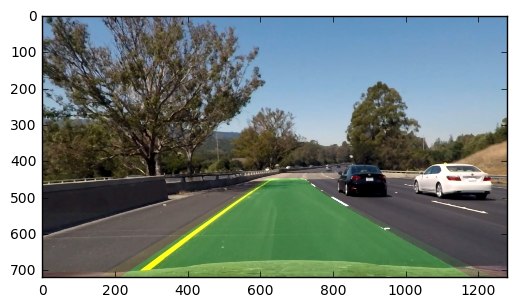

In [286]:
# process output file. iteration 3
image = mpimg.imread('test_images/test6.jpg')
out = frame_line.pipeline(image)
print out.dtype
plt.imshow(out, cmap='gray')

In [287]:
from moviepy.editor import VideoFileClip
frame_line = Line()
vid_output = 'challeng_1_solve.mp4'
clip_source = VideoFileClip("challenge_video.mp4")
vid_clip = clip_source.fl_image(frame_line.pipeline) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

305.753068658
[MoviePy] >>>> Building video challeng_1_solve.mp4
[MoviePy] Writing video challeng_1_solve.mp4



  0%|                                                                                                        | 0/485 [00:00<?, ?it/s]

697.270938743



  0%|▏                                                                                               | 1/485 [00:00<01:58,  4.10it/s]

1548.15127869



  0%|▍                                                                                               | 2/485 [00:00<01:57,  4.11it/s]

278.720746192



  1%|▌                                                                                               | 3/485 [00:00<01:56,  4.14it/s]

145.37578215



  1%|▊                                                                                               | 4/485 [00:00<01:57,  4.09it/s]

118.563912584



  1%|▉                                                                                               | 5/485 [00:01<01:56,  4.12it/s]

94.3973088466



  1%|█▏                                                                                              | 6/485 [00:01<01:58,  4.06it/s]

75.0579428763



  1%|█▍                                                                                              | 7/485 [00:01<01:56,  4.10it/s]

75.6907292179



  2%|█▌                                                                                              | 8/485 [00:01<01:54,  4.18it/s]

135.63140968



  2%|█▊                                                                                              | 9/485 [00:02<01:52,  4.24it/s]

245.342538121



  2%|█▉                                                                                             | 10/485 [00:02<01:52,  4.23it/s]

368.497672071



  2%|██▏                                                                                            | 11/485 [00:02<01:59,  3.96it/s]

407.208261388



  2%|██▎                                                                                            | 12/485 [00:02<02:04,  3.80it/s]


182.385718941



  3%|██▌                                                                                            | 13/485 [00:03<02:10,  3.61it/s]

41.4766351035



  3%|██▋                                                                                            | 14/485 [00:03<02:11,  3.57it/s]

461.627987198



  3%|██▉                                                                                            | 15/485 [00:03<02:04,  3.78it/s]

1438.63925422



  3%|███▏                                                                                           | 16/485 [00:04<01:58,  3.94it/s]

3468.52310045



  4%|███▎                                                                                           | 17/485 [00:04<01:58,  3.94it/s]

476.797629546



  4%|███▌                                                                                           | 18/485 [00:04<01:56,  4.02it/s]

103.637365938



  4%|███▋                                                                                           | 19/485 [00:04<01:53,  4.09it/s]

313.478483642



  4%|███▉                                                                                           | 20/485 [00:05<01:53,  4.08it/s]

9345.95912152



  4%|████                                                                                           | 21/485 [00:05<01:54,  4.06it/s]

174.776172532



  5%|████▎                                                                                          | 22/485 [00:05<01:51,  4.17it/s]

43.1414911151



  5%|████▌                                                                                          | 23/485 [00:05<01:49,  4.20it/s]

101.64760847



  5%|████▋                                                                                          | 24/485 [00:05<01:48,  4.26it/s]

157.211843159



  5%|████▉                                                                                          | 25/485 [00:06<01:47,  4.29it/s]

138.69190583



  5%|█████                                                                                          | 26/485 [00:06<01:49,  4.20it/s]

202.465196648



  6%|█████▎                                                                                         | 27/485 [00:06<01:53,  4.03it/s]

277.914946891



  6%|█████▍                                                                                         | 28/485 [00:06<01:54,  4.00it/s]

158.198031623



  6%|█████▋                                                                                         | 29/485 [00:07<01:53,  4.01it/s]

14.7084448028



  6%|█████▉                                                                                         | 30/485 [00:07<01:53,  4.02it/s]

706.433146153



  6%|██████                                                                                         | 31/485 [00:07<01:50,  4.10it/s]

208.584906733



  7%|██████▎                                                                                        | 32/485 [00:07<01:51,  4.08it/s]

685.558146252



  7%|██████▍                                                                                        | 33/485 [00:08<01:49,  4.13it/s]

176.830058789



  7%|██████▋                                                                                        | 34/485 [00:08<01:52,  4.02it/s]

45.356617641



  7%|██████▊                                                                                        | 35/485 [00:08<01:50,  4.07it/s]

43.469151218



  7%|███████                                                                                        | 36/485 [00:08<01:49,  4.10it/s]

66.4854223236



  8%|███████▏                                                                                       | 37/485 [00:09<01:48,  4.15it/s]

110.505336085



  8%|███████▍                                                                                       | 38/485 [00:09<01:47,  4.16it/s]

1300.0992601



  8%|███████▋                                                                                       | 39/485 [00:09<01:46,  4.20it/s]

92.2014315837



  8%|███████▊                                                                                       | 40/485 [00:09<01:50,  4.04it/s]

39.7779270847



  8%|████████                                                                                       | 41/485 [00:10<01:48,  4.08it/s]

228.32347316



  9%|████████▏                                                                                      | 42/485 [00:10<01:48,  4.06it/s]

170.887628477



  9%|████████▍                                                                                      | 43/485 [00:10<01:48,  4.06it/s]

8.78297373231



  9%|████████▌                                                                                      | 44/485 [00:10<01:46,  4.16it/s]

146.58110158



  9%|████████▊                                                                                      | 45/485 [00:11<01:45,  4.19it/s]

1664.70025741



  9%|█████████                                                                                      | 46/485 [00:11<01:43,  4.22it/s]

1451.09306144



 10%|█████████▏                                                                                     | 47/485 [00:11<01:43,  4.23it/s]

10101.6915618



 10%|█████████▍                                                                                     | 48/485 [00:11<01:43,  4.23it/s]

3339.63784324



 10%|█████████▌                                                                                     | 49/485 [00:12<01:42,  4.24it/s]

1044.20172031



 10%|█████████▊                                                                                     | 50/485 [00:12<01:42,  4.24it/s]

334.156436954



 11%|█████████▉                                                                                     | 51/485 [00:12<01:42,  4.23it/s]

656.702960592



 11%|██████████▏                                                                                    | 52/485 [00:12<01:47,  4.02it/s]

1153.68566888



 11%|██████████▍                                                                                    | 53/485 [00:13<01:46,  4.05it/s]

1581.10643409



 11%|██████████▌                                                                                    | 54/485 [00:13<01:44,  4.12it/s]

36363.3905025



 11%|██████████▊                                                                                    | 55/485 [00:13<01:43,  4.15it/s]

226.279324307



 12%|██████████▉                                                                                    | 56/485 [00:13<01:43,  4.16it/s]

204.143741785



 12%|███████████▏                                                                                   | 57/485 [00:13<01:43,  4.14it/s]

18.1164271777



 12%|███████████▎                                                                                   | 58/485 [00:14<01:44,  4.08it/s]

31.4742816101



 12%|███████████▌                                                                                   | 59/485 [00:14<01:45,  4.03it/s]

173.533167469



 12%|███████████▊                                                                                   | 60/485 [00:14<01:44,  4.07it/s]

33.149245783



 13%|███████████▉                                                                                   | 61/485 [00:14<01:43,  4.09it/s]

29.6357943232



 13%|████████████▏                                                                                  | 62/485 [00:15<01:46,  3.96it/s]

42.2414094463



 13%|████████████▎                                                                                  | 63/485 [00:15<01:46,  3.96it/s]

647.314352244



 13%|████████████▌                                                                                  | 64/485 [00:15<01:46,  3.94it/s]

1117.76389499



 13%|████████████▋                                                                                  | 65/485 [00:15<01:46,  3.95it/s]

1370.01317194



 14%|████████████▉                                                                                  | 66/485 [00:16<01:45,  3.98it/s]

2673.66792755



 14%|█████████████                                                                                  | 67/485 [00:16<01:43,  4.02it/s]

16197.9121123



 14%|█████████████▎                                                                                 | 68/485 [00:16<01:43,  4.04it/s]

711.654657615



 14%|█████████████▌                                                                                 | 69/485 [00:16<01:40,  4.13it/s]

54.8173323452



 14%|█████████████▋                                                                                 | 70/485 [00:17<01:40,  4.15it/s]

45.4428209986



 15%|█████████████▉                                                                                 | 71/485 [00:17<01:40,  4.13it/s]

0.210159925232



 15%|██████████████                                                                                 | 72/485 [00:17<01:39,  4.17it/s]

423.701719359



 15%|██████████████▎                                                                                | 73/485 [00:17<01:39,  4.16it/s]

487.965100519



 15%|██████████████▍                                                                                | 74/485 [00:18<01:38,  4.17it/s]

168.831293814



 15%|██████████████▋                                                                                | 75/485 [00:18<01:38,  4.18it/s]

198.381104693



 16%|██████████████▉                                                                                | 76/485 [00:18<01:37,  4.19it/s]

182.54812165



 16%|███████████████                                                                                | 77/485 [00:18<01:40,  4.05it/s]

183.755351121



 16%|███████████████▎                                                                               | 78/485 [00:19<01:39,  4.10it/s]

197.172880626



 16%|███████████████▍                                                                               | 79/485 [00:19<01:39,  4.10it/s]

213.575277828



 16%|███████████████▋                                                                               | 80/485 [00:19<01:40,  4.01it/s]

201.853093781



 17%|███████████████▊                                                                               | 81/485 [00:19<01:39,  4.07it/s]

267.714716761



 17%|████████████████                                                                               | 82/485 [00:20<01:37,  4.14it/s]

416.906481459



 17%|████████████████▎                                                                              | 83/485 [00:20<01:37,  4.10it/s]

484.3910331



 17%|████████████████▍                                                                              | 84/485 [00:20<01:37,  4.13it/s]

468.296650362



 18%|████████████████▋                                                                              | 85/485 [00:20<01:35,  4.18it/s]

421.020541086



 18%|████████████████▊                                                                              | 86/485 [00:21<01:41,  3.92it/s]

368.018758675



 18%|█████████████████                                                                              | 87/485 [00:21<01:40,  3.94it/s]

297.937747075



 18%|█████████████████▏                                                                             | 88/485 [00:21<01:39,  4.01it/s]

249.151795124



 18%|█████████████████▍                                                                             | 89/485 [00:21<01:41,  3.88it/s]

225.069314912



 19%|█████████████████▋                                                                             | 90/485 [00:22<01:41,  3.88it/s]

233.858326567



 19%|█████████████████▊                                                                             | 91/485 [00:22<01:40,  3.92it/s]

221.672988656



 19%|██████████████████                                                                             | 92/485 [00:22<01:39,  3.95it/s]

207.477755464



 19%|██████████████████▏                                                                            | 93/485 [00:22<01:37,  4.01it/s]

187.556005726



 19%|██████████████████▍                                                                            | 94/485 [00:23<01:36,  4.05it/s]

176.039951947



 20%|██████████████████▌                                                                            | 95/485 [00:23<01:35,  4.08it/s]

159.632253599



 20%|██████████████████▊                                                                            | 96/485 [00:23<01:36,  4.03it/s]

141.698539228



 20%|███████████████████                                                                            | 97/485 [00:23<01:36,  4.00it/s]

130.882163925



 20%|███████████████████▏                                                                           | 98/485 [00:24<01:36,  4.01it/s]

122.064735472



 20%|███████████████████▍                                                                           | 99/485 [00:24<01:36,  3.99it/s]

114.125001128



 21%|███████████████████▍                                                                          | 100/485 [00:24<01:36,  4.00it/s]

110.153284633



 21%|███████████████████▌                                                                          | 101/485 [00:24<01:34,  4.05it/s]

109.184237775



 21%|███████████████████▊                                                                          | 102/485 [00:25<01:34,  4.05it/s]

108.250745184



 21%|███████████████████▉                                                                          | 103/485 [00:25<01:34,  4.03it/s]

108.307246136



 21%|████████████████████▏                                                                         | 104/485 [00:25<01:34,  4.03it/s]

110.686601179



 22%|████████████████████▎                                                                         | 105/485 [00:25<01:33,  4.05it/s]

111.922607132



 22%|████████████████████▌                                                                         | 106/485 [00:26<01:36,  3.93it/s]

119.312113494



 22%|████████████████████▋                                                                         | 107/485 [00:26<01:34,  3.98it/s]

132.593962175



 22%|████████████████████▉                                                                         | 108/485 [00:26<01:33,  4.05it/s]

156.495601239



 22%|█████████████████████▏                                                                        | 109/485 [00:26<01:31,  4.09it/s]

193.121167504



 23%|█████████████████████▎                                                                        | 110/485 [00:27<01:33,  4.02it/s]

250.768665963



 23%|█████████████████████▌                                                                        | 111/485 [00:27<01:34,  3.96it/s]

370.693787967



 23%|█████████████████████▋                                                                        | 112/485 [00:27<01:39,  3.77it/s]

546.345263661



 23%|█████████████████████▉                                                                        | 113/485 [00:27<01:35,  3.91it/s]

793.172372107



 24%|██████████████████████                                                                        | 114/485 [00:28<01:34,  3.93it/s]

991.446543323



 24%|██████████████████████▎                                                                       | 115/485 [00:28<01:34,  3.91it/s]

1122.49991234



 24%|██████████████████████▍                                                                       | 116/485 [00:28<01:33,  3.93it/s]

1115.16676341



 24%|██████████████████████▋                                                                       | 117/485 [00:28<01:32,  3.98it/s]

993.076488173



 24%|██████████████████████▊                                                                       | 118/485 [00:29<01:32,  3.95it/s]

990.23295243



 25%|███████████████████████                                                                       | 119/485 [00:29<01:36,  3.80it/s]

1138.06226418



 25%|███████████████████████▎                                                                      | 120/485 [00:29<01:42,  3.55it/s]

1416.44344596



 25%|███████████████████████▍                                                                      | 121/485 [00:30<01:45,  3.46it/s]

2007.57348831



 25%|███████████████████████▋                                                                      | 122/485 [00:30<01:53,  3.20it/s]

5180.34965304



 25%|███████████████████████▊                                                                      | 123/485 [00:30<01:56,  3.10it/s]

3325.41542615



 26%|████████████████████████                                                                      | 124/485 [00:31<01:51,  3.23it/s]

3989.39327514



 26%|████████████████████████▏                                                                     | 125/485 [00:31<01:44,  3.43it/s]

30265.9291846



 26%|████████████████████████▍                                                                     | 126/485 [00:31<01:42,  3.51it/s]

2870.97699218



 26%|████████████████████████▌                                                                     | 127/485 [00:31<01:38,  3.63it/s]

1675.47758296



 26%|████████████████████████▊                                                                     | 128/485 [00:32<01:35,  3.74it/s]

1330.47398927



 27%|█████████████████████████                                                                     | 129/485 [00:32<01:32,  3.87it/s]

334.862510103



 27%|█████████████████████████▏                                                                    | 130/485 [00:32<01:30,  3.92it/s]

95.5883748931



 27%|█████████████████████████▍                                                                    | 131/485 [00:32<01:29,  3.96it/s]

86.1855711704



 27%|█████████████████████████▌                                                                    | 132/485 [00:33<01:29,  3.96it/s]

73.7674572945



 27%|█████████████████████████▊                                                                    | 133/485 [00:33<01:35,  3.69it/s]

51.630675043



 28%|█████████████████████████▉                                                                    | 134/485 [00:33<01:41,  3.47it/s]

34.9551404242



 28%|██████████████████████████▏                                                                   | 135/485 [00:33<01:39,  3.51it/s]

30.7921540663



 28%|██████████████████████████▎                                                                   | 136/485 [00:34<01:39,  3.50it/s]

52.2313299683



 28%|██████████████████████████▌                                                                   | 137/485 [00:34<01:39,  3.49it/s]

51.8678980056



 28%|██████████████████████████▋                                                                   | 138/485 [00:34<01:37,  3.56it/s]

44.2338718364



 29%|██████████████████████████▉                                                                   | 139/485 [00:35<01:35,  3.62it/s]

54.6980367084



 29%|███████████████████████████▏                                                                  | 140/485 [00:35<01:36,  3.59it/s]

73.0952520318



 29%|███████████████████████████▎                                                                  | 141/485 [00:35<01:33,  3.66it/s]

103.815050329



 29%|███████████████████████████▌                                                                  | 142/485 [00:35<01:31,  3.76it/s]

155.878895909



 29%|███████████████████████████▋                                                                  | 143/485 [00:36<01:28,  3.85it/s]

208.965510976



 30%|███████████████████████████▉                                                                  | 144/485 [00:36<01:26,  3.93it/s]

282.307925047



 30%|████████████████████████████                                                                  | 145/485 [00:36<01:27,  3.89it/s]

278.64907398



 30%|████████████████████████████▎                                                                 | 146/485 [00:36<01:27,  3.88it/s]

223.581930349



 30%|████████████████████████████▍                                                                 | 147/485 [00:37<01:27,  3.88it/s]

304.449834779



 31%|████████████████████████████▋                                                                 | 148/485 [00:37<01:27,  3.86it/s]

452.633194962



 31%|████████████████████████████▉                                                                 | 149/485 [00:37<01:26,  3.87it/s]

707.025394618



 31%|█████████████████████████████                                                                 | 150/485 [00:37<01:27,  3.84it/s]

1264.16785996



 31%|█████████████████████████████▎                                                                | 151/485 [00:38<01:28,  3.76it/s]

1079.89636411



 31%|█████████████████████████████▍                                                                | 152/485 [00:38<01:29,  3.71it/s]

1054.09341369



 32%|█████████████████████████████▋                                                                | 153/485 [00:38<01:29,  3.72it/s]

686.0279022



 32%|█████████████████████████████▊                                                                | 154/485 [00:39<01:31,  3.61it/s]

334.567548277



 32%|██████████████████████████████                                                                | 155/485 [00:39<01:28,  3.74it/s]

127.451314743



 32%|██████████████████████████████▏                                                               | 156/485 [00:39<01:27,  3.74it/s]

136.812272792



 32%|██████████████████████████████▍                                                               | 157/485 [00:39<01:25,  3.83it/s]

80.6445307078



 33%|██████████████████████████████▌                                                               | 158/485 [00:40<01:23,  3.89it/s]

39.4059349562



 33%|██████████████████████████████▊                                                               | 159/485 [00:40<01:25,  3.81it/s]

20.5529995328



 33%|███████████████████████████████                                                               | 160/485 [00:40<01:28,  3.69it/s]

30.0509087362



 33%|███████████████████████████████▏                                                              | 161/485 [00:40<01:25,  3.81it/s]

20.4031632916



 33%|███████████████████████████████▍                                                              | 162/485 [00:41<01:29,  3.62it/s]

59.3252287407



 34%|███████████████████████████████▌                                                              | 163/485 [00:41<01:28,  3.65it/s]

14.3975219784



 34%|███████████████████████████████▊                                                              | 164/485 [00:41<01:27,  3.67it/s]

637.207941821



 34%|███████████████████████████████▉                                                              | 165/485 [00:41<01:25,  3.74it/s]

21.1882257963



 34%|████████████████████████████████▏                                                             | 166/485 [00:42<01:23,  3.80it/s]

149.623301616



 34%|████████████████████████████████▎                                                             | 167/485 [00:42<01:23,  3.81it/s]

156.174844443



 35%|████████████████████████████████▌                                                             | 168/485 [00:42<01:23,  3.80it/s]

65.3107202992



 35%|████████████████████████████████▊                                                             | 169/485 [00:42<01:22,  3.84it/s]

92.4725363299



 35%|████████████████████████████████▉                                                             | 170/485 [00:43<01:22,  3.80it/s]

157.739200835



 35%|█████████████████████████████████▏                                                            | 171/485 [00:43<01:24,  3.70it/s]

146.119713776



 35%|█████████████████████████████████▎                                                            | 172/485 [00:43<01:23,  3.73it/s]

153.192222566



 36%|█████████████████████████████████▌                                                            | 173/485 [00:44<01:24,  3.70it/s]

184.437731151



 36%|█████████████████████████████████▋                                                            | 174/485 [00:44<01:24,  3.68it/s]

221.203457379



 36%|█████████████████████████████████▉                                                            | 175/485 [00:44<01:24,  3.65it/s]

265.625560432



 36%|██████████████████████████████████                                                            | 176/485 [00:44<01:28,  3.48it/s]

318.99907559



 36%|██████████████████████████████████▎                                                           | 177/485 [00:45<01:27,  3.52it/s]

386.506614569



 37%|██████████████████████████████████▍                                                           | 178/485 [00:45<01:23,  3.68it/s]

469.309341275



 37%|██████████████████████████████████▋                                                           | 179/485 [00:45<01:21,  3.74it/s]

563.965817433



 37%|██████████████████████████████████▉                                                           | 180/485 [00:46<01:21,  3.75it/s]

613.342751674



 37%|███████████████████████████████████                                                           | 181/485 [00:46<01:21,  3.71it/s]

510.319330674



 38%|███████████████████████████████████▎                                                          | 182/485 [00:46<01:20,  3.75it/s]

409.717238752



 38%|███████████████████████████████████▍                                                          | 183/485 [00:46<01:22,  3.66it/s]

309.408873862



 38%|███████████████████████████████████▋                                                          | 184/485 [00:47<01:21,  3.67it/s]

230.779538475



 38%|███████████████████████████████████▊                                                          | 185/485 [00:47<01:20,  3.72it/s]

191.607293965



 38%|████████████████████████████████████                                                          | 186/485 [00:47<01:17,  3.84it/s]

170.166415418



 39%|████████████████████████████████████▏                                                         | 187/485 [00:47<01:17,  3.84it/s]

154.628717645



 39%|████████████████████████████████████▍                                                         | 188/485 [00:48<01:15,  3.95it/s]

146.450840393



 39%|████████████████████████████████████▋                                                         | 189/485 [00:48<01:13,  4.03it/s]

157.554563696



 39%|████████████████████████████████████▊                                                         | 190/485 [00:48<01:11,  4.11it/s]

168.504055712



 39%|█████████████████████████████████████                                                         | 191/485 [00:48<01:11,  4.11it/s]

165.941294794



 40%|█████████████████████████████████████▏                                                        | 192/485 [00:49<01:10,  4.15it/s]

150.440837371



 40%|█████████████████████████████████████▍                                                        | 193/485 [00:49<01:09,  4.18it/s]

134.027121578



 40%|█████████████████████████████████████▌                                                        | 194/485 [00:49<01:10,  4.14it/s]

108.264148073



 40%|█████████████████████████████████████▊                                                        | 195/485 [00:49<01:09,  4.16it/s]

85.3651686347



 40%|█████████████████████████████████████▉                                                        | 196/485 [00:50<01:15,  3.83it/s]

71.5188719169



 41%|██████████████████████████████████████▏                                                       | 197/485 [00:50<01:15,  3.83it/s]

71.4251450738



 41%|██████████████████████████████████████▍                                                       | 198/485 [00:50<01:13,  3.91it/s]

79.1866897306



 41%|██████████████████████████████████████▌                                                       | 199/485 [00:50<01:11,  3.98it/s]

106.047434548



 41%|██████████████████████████████████████▊                                                       | 200/485 [00:51<01:13,  3.86it/s]

127.679844631



 41%|██████████████████████████████████████▉                                                       | 201/485 [00:51<01:12,  3.90it/s]

162.385780016



 42%|███████████████████████████████████████▏                                                      | 202/485 [00:51<01:11,  3.97it/s]

216.550157014



 42%|███████████████████████████████████████▎                                                      | 203/485 [00:51<01:10,  3.98it/s]

256.278512174



 42%|███████████████████████████████████████▌                                                      | 204/485 [00:52<01:09,  4.02it/s]

253.197916942



 42%|███████████████████████████████████████▋                                                      | 205/485 [00:52<01:08,  4.08it/s]

202.532905183



 42%|███████████████████████████████████████▉                                                      | 206/485 [00:52<01:07,  4.11it/s]

229.639510911



 43%|████████████████████████████████████████                                                      | 207/485 [00:52<01:07,  4.12it/s]

247.096952504



 43%|████████████████████████████████████████▎                                                     | 208/485 [00:53<01:07,  4.08it/s]

225.326567397



 43%|████████████████████████████████████████▌                                                     | 209/485 [00:53<01:09,  4.00it/s]

199.512347544



 43%|████████████████████████████████████████▋                                                     | 210/485 [00:53<01:08,  4.03it/s]

177.19577889



 44%|████████████████████████████████████████▉                                                     | 211/485 [00:53<01:07,  4.07it/s]

160.52316037



 44%|█████████████████████████████████████████                                                     | 212/485 [00:54<01:06,  4.11it/s]

145.723332071



 44%|█████████████████████████████████████████▎                                                    | 213/485 [00:54<01:05,  4.13it/s]

135.510448529



 44%|█████████████████████████████████████████▍                                                    | 214/485 [00:54<01:04,  4.19it/s]

144.505675111



 44%|█████████████████████████████████████████▋                                                    | 215/485 [00:54<01:06,  4.05it/s]

165.918518487



 45%|█████████████████████████████████████████▊                                                    | 216/485 [00:55<01:09,  3.89it/s]

193.517599556



 45%|██████████████████████████████████████████                                                    | 217/485 [00:55<01:09,  3.83it/s]

216.521639647



 45%|██████████████████████████████████████████▎                                                   | 218/485 [00:55<01:07,  3.97it/s]

205.50730894



 45%|██████████████████████████████████████████▍                                                   | 219/485 [00:55<01:07,  3.95it/s]

170.893702912



 45%|██████████████████████████████████████████▋                                                   | 220/485 [00:56<01:08,  3.87it/s]

135.526908457



 46%|██████████████████████████████████████████▊                                                   | 221/485 [00:56<01:08,  3.86it/s]

124.067828748



 46%|███████████████████████████████████████████                                                   | 222/485 [00:56<01:15,  3.50it/s]

116.150868206



 46%|███████████████████████████████████████████▏                                                  | 223/485 [00:57<01:21,  3.22it/s]

115.480904769



 46%|███████████████████████████████████████████▍                                                  | 224/485 [00:57<01:22,  3.15it/s]

135.650071809



 46%|███████████████████████████████████████████▌                                                  | 225/485 [00:57<01:21,  3.20it/s]

203.677316027



 47%|███████████████████████████████████████████▊                                                  | 226/485 [00:57<01:19,  3.25it/s]

308.949858631



 47%|███████████████████████████████████████████▉                                                  | 227/485 [00:58<01:18,  3.30it/s]

296.891456479



 47%|████████████████████████████████████████████▏                                                 | 228/485 [00:58<01:19,  3.25it/s]

275.12460566



 47%|████████████████████████████████████████████▍                                                 | 229/485 [00:58<01:14,  3.41it/s]

221.306061009



 47%|████████████████████████████████████████████▌                                                 | 230/485 [00:59<01:14,  3.45it/s]

148.115854228



 48%|████████████████████████████████████████████▊                                                 | 231/485 [00:59<01:11,  3.54it/s]

99.4884494867



 48%|████████████████████████████████████████████▉                                                 | 232/485 [00:59<01:12,  3.48it/s]

77.4605009192



 48%|█████████████████████████████████████████████▏                                                | 233/485 [01:00<01:23,  3.03it/s]

69.8489875886



 48%|█████████████████████████████████████████████▎                                                | 234/485 [01:00<01:23,  3.01it/s]

37.8370537334



 48%|█████████████████████████████████████████████▌                                                | 235/485 [01:00<01:19,  3.16it/s]

20.6955107013



 49%|█████████████████████████████████████████████▋                                                | 236/485 [01:01<01:13,  3.37it/s]

41.2817100982



 49%|█████████████████████████████████████████████▉                                                | 237/485 [01:01<01:11,  3.48it/s]

176.310474464



 49%|██████████████████████████████████████████████▏                                               | 238/485 [01:01<01:08,  3.60it/s]

83.4977878818



 49%|██████████████████████████████████████████████▎                                               | 239/485 [01:01<01:06,  3.70it/s]

116.166485015



 49%|██████████████████████████████████████████████▌                                               | 240/485 [01:02<01:06,  3.69it/s]

136.120112763



 50%|██████████████████████████████████████████████▋                                               | 241/485 [01:02<01:03,  3.81it/s]

154.125547301



 50%|██████████████████████████████████████████████▉                                               | 242/485 [01:02<01:03,  3.83it/s]

161.387739414



 50%|███████████████████████████████████████████████                                               | 243/485 [01:02<01:03,  3.83it/s]

42.7013032504



 50%|███████████████████████████████████████████████▎                                              | 244/485 [01:03<01:02,  3.84it/s]

179.133071275



 51%|███████████████████████████████████████████████▍                                              | 245/485 [01:03<01:01,  3.92it/s]

198.716846707



 51%|███████████████████████████████████████████████▋                                              | 246/485 [01:03<01:00,  3.95it/s]

199.235982066



 51%|███████████████████████████████████████████████▊                                              | 247/485 [01:03<01:00,  3.94it/s]

189.229414383



 51%|████████████████████████████████████████████████                                              | 248/485 [01:04<01:00,  3.91it/s]

184.139722447



 51%|████████████████████████████████████████████████▎                                             | 249/485 [01:04<01:00,  3.93it/s]

189.837764929



 52%|████████████████████████████████████████████████▍                                             | 250/485 [01:04<00:59,  3.94it/s]

169.746576893



 52%|████████████████████████████████████████████████▋                                             | 251/485 [01:04<00:59,  3.95it/s]

95.5209718406



 52%|████████████████████████████████████████████████▊                                             | 252/485 [01:05<00:59,  3.94it/s]

98.6145245886



 52%|█████████████████████████████████████████████████                                             | 253/485 [01:05<00:58,  3.96it/s]

5034.32397914



 52%|█████████████████████████████████████████████████▏                                            | 254/485 [01:05<00:57,  4.02it/s]

178.753274833



 53%|█████████████████████████████████████████████████▍                                            | 255/485 [01:05<01:00,  3.81it/s]

177.114120644



 53%|█████████████████████████████████████████████████▌                                            | 256/485 [01:06<00:59,  3.86it/s]

188.808747676



 53%|█████████████████████████████████████████████████▊                                            | 257/485 [01:06<00:59,  3.85it/s]

189.593449675



 53%|██████████████████████████████████████████████████                                            | 258/485 [01:06<00:59,  3.83it/s]

184.35125815



 53%|██████████████████████████████████████████████████▏                                           | 259/485 [01:06<00:58,  3.88it/s]

176.051899721



 54%|██████████████████████████████████████████████████▍                                           | 260/485 [01:07<00:58,  3.86it/s]

166.476501219



 54%|██████████████████████████████████████████████████▌                                           | 261/485 [01:07<00:58,  3.80it/s]

164.150490253



 54%|██████████████████████████████████████████████████▊                                           | 262/485 [01:07<00:58,  3.82it/s]

163.935214225



 54%|██████████████████████████████████████████████████▉                                           | 263/485 [01:07<00:57,  3.88it/s]

167.911209728



 54%|███████████████████████████████████████████████████▏                                          | 264/485 [01:08<00:57,  3.86it/s]

173.351722617



 55%|███████████████████████████████████████████████████▎                                          | 265/485 [01:08<00:56,  3.91it/s]

182.883855734



 55%|███████████████████████████████████████████████████▌                                          | 266/485 [01:08<00:55,  3.93it/s]

202.579732699



 55%|███████████████████████████████████████████████████▋                                          | 267/485 [01:08<00:56,  3.85it/s]

238.81277415



 55%|███████████████████████████████████████████████████▉                                          | 268/485 [01:09<00:55,  3.89it/s]

271.461704312



 55%|████████████████████████████████████████████████████▏                                         | 269/485 [01:09<00:55,  3.91it/s]

287.580325322



 56%|████████████████████████████████████████████████████▎                                         | 270/485 [01:09<00:55,  3.89it/s]

277.203580824



 56%|████████████████████████████████████████████████████▌                                         | 271/485 [01:10<00:55,  3.86it/s]

227.186922905



 56%|████████████████████████████████████████████████████▋                                         | 272/485 [01:10<00:55,  3.86it/s]

158.231587057



 56%|████████████████████████████████████████████████████▉                                         | 273/485 [01:10<00:54,  3.87it/s]

106.815331614



 56%|█████████████████████████████████████████████████████                                         | 274/485 [01:10<00:53,  3.91it/s]

74.5981854118



 57%|█████████████████████████████████████████████████████▎                                        | 275/485 [01:11<00:53,  3.89it/s]

57.5935782913



 57%|█████████████████████████████████████████████████████▍                                        | 276/485 [01:11<00:56,  3.71it/s]

46.9410440282



 57%|█████████████████████████████████████████████████████▋                                        | 277/485 [01:11<00:54,  3.83it/s]

42.6135415018



 57%|█████████████████████████████████████████████████████▉                                        | 278/485 [01:11<00:56,  3.67it/s]

49.0679142408



 58%|██████████████████████████████████████████████████████                                        | 279/485 [01:12<00:57,  3.58it/s]

65.4073984414



 58%|██████████████████████████████████████████████████████▎                                       | 280/485 [01:12<00:56,  3.60it/s]

114.50616888



 58%|██████████████████████████████████████████████████████▍                                       | 281/485 [01:12<00:55,  3.69it/s]

164.121336364



 58%|██████████████████████████████████████████████████████▋                                       | 282/485 [01:12<00:54,  3.71it/s]

298.039188441



 58%|██████████████████████████████████████████████████████▊                                       | 283/485 [01:13<00:55,  3.67it/s]

390.179861526



 59%|███████████████████████████████████████████████████████                                       | 284/485 [01:13<00:53,  3.74it/s]

429.58180733



 59%|███████████████████████████████████████████████████████▏                                      | 285/485 [01:13<00:53,  3.75it/s]

404.337562275



 59%|███████████████████████████████████████████████████████▍                                      | 286/485 [01:14<00:52,  3.76it/s]

330.806777029



 59%|███████████████████████████████████████████████████████▌                                      | 287/485 [01:14<00:54,  3.62it/s]

292.929661836



 59%|███████████████████████████████████████████████████████▊                                      | 288/485 [01:14<00:54,  3.59it/s]

253.994510737



 60%|████████████████████████████████████████████████████████                                      | 289/485 [01:14<00:54,  3.58it/s]

232.905572183



 60%|████████████████████████████████████████████████████████▏                                     | 290/485 [01:15<00:53,  3.61it/s]

215.592880172



 60%|████████████████████████████████████████████████████████▍                                     | 291/485 [01:15<00:53,  3.64it/s]

209.512902455



 60%|████████████████████████████████████████████████████████▌                                     | 292/485 [01:15<00:53,  3.60it/s]

213.355599326



 60%|████████████████████████████████████████████████████████▊                                     | 293/485 [01:15<00:53,  3.61it/s]

212.229630961



 61%|████████████████████████████████████████████████████████▉                                     | 294/485 [01:16<00:52,  3.65it/s]

235.602064742



 61%|█████████████████████████████████████████████████████████▏                                    | 295/485 [01:16<00:53,  3.54it/s]

247.418776463



 61%|█████████████████████████████████████████████████████████▎                                    | 296/485 [01:16<00:52,  3.60it/s]

238.787845613



 61%|█████████████████████████████████████████████████████████▌                                    | 297/485 [01:17<00:51,  3.65it/s]

254.970565662



 61%|█████████████████████████████████████████████████████████▊                                    | 298/485 [01:17<00:50,  3.69it/s]

251.280953143



 62%|█████████████████████████████████████████████████████████▉                                    | 299/485 [01:17<00:50,  3.68it/s]

232.802942463



 62%|██████████████████████████████████████████████████████████▏                                   | 300/485 [01:17<00:50,  3.63it/s]

208.122628986



 62%|██████████████████████████████████████████████████████████▎                                   | 301/485 [01:18<00:49,  3.68it/s]

186.935995543



 62%|██████████████████████████████████████████████████████████▌                                   | 302/485 [01:18<00:50,  3.62it/s]

172.088495126



 62%|██████████████████████████████████████████████████████████▋                                   | 303/485 [01:18<00:50,  3.62it/s]

159.672028501



 63%|██████████████████████████████████████████████████████████▉                                   | 304/485 [01:19<00:49,  3.64it/s]

143.06345447



 63%|███████████████████████████████████████████████████████████                                   | 305/485 [01:19<00:48,  3.70it/s]

127.548366293



 63%|███████████████████████████████████████████████████████████▎                                  | 306/485 [01:19<00:49,  3.64it/s]

92.798225105



 63%|███████████████████████████████████████████████████████████▌                                  | 307/485 [01:19<00:48,  3.64it/s]

1713.90314898



 64%|███████████████████████████████████████████████████████████▋                                  | 308/485 [01:20<00:48,  3.67it/s]

117.196434181



 64%|███████████████████████████████████████████████████████████▉                                  | 309/485 [01:20<00:47,  3.74it/s]

195.78882171



 64%|████████████████████████████████████████████████████████████                                  | 310/485 [01:20<00:47,  3.67it/s]

249.728227419



 64%|████████████████████████████████████████████████████████████▎                                 | 311/485 [01:20<00:47,  3.70it/s]

328.635773471



 64%|████████████████████████████████████████████████████████████▍                                 | 312/485 [01:21<00:45,  3.77it/s]

438.272481237



 65%|████████████████████████████████████████████████████████████▋                                 | 313/485 [01:21<00:45,  3.79it/s]

528.299811824



 65%|████████████████████████████████████████████████████████████▊                                 | 314/485 [01:21<00:45,  3.77it/s]

555.733368202



 65%|█████████████████████████████████████████████████████████████                                 | 315/485 [01:21<00:44,  3.80it/s]

522.086268165



 65%|█████████████████████████████████████████████████████████████▏                                | 316/485 [01:22<00:44,  3.77it/s]

464.427612943



 65%|█████████████████████████████████████████████████████████████▍                                | 317/485 [01:22<00:44,  3.80it/s]

409.385184066



 66%|█████████████████████████████████████████████████████████████▋                                | 318/485 [01:22<00:43,  3.83it/s]

362.335731874



 66%|█████████████████████████████████████████████████████████████▊                                | 319/485 [01:22<00:43,  3.84it/s]

334.246483134



 66%|██████████████████████████████████████████████████████████████                                | 320/485 [01:23<00:43,  3.80it/s]

325.869073006



 66%|██████████████████████████████████████████████████████████████▏                               | 321/485 [01:23<00:43,  3.79it/s]

334.478352386



 66%|██████████████████████████████████████████████████████████████▍                               | 322/485 [01:23<00:43,  3.78it/s]

394.165194692



 67%|██████████████████████████████████████████████████████████████▌                               | 323/485 [01:24<00:43,  3.72it/s]

414.831193657



 67%|██████████████████████████████████████████████████████████████▊                               | 324/485 [01:24<00:44,  3.59it/s]

487.81877495



 67%|██████████████████████████████████████████████████████████████▉                               | 325/485 [01:24<00:45,  3.55it/s]

513.394453214



 67%|███████████████████████████████████████████████████████████████▏                              | 326/485 [01:24<00:45,  3.50it/s]

508.653234099



 67%|███████████████████████████████████████████████████████████████▍                              | 327/485 [01:25<00:45,  3.50it/s]

482.306082265



 68%|███████████████████████████████████████████████████████████████▌                              | 328/485 [01:25<00:45,  3.44it/s]

400.280894764



 68%|███████████████████████████████████████████████████████████████▊                              | 329/485 [01:25<00:44,  3.51it/s]

398.78484795



 68%|███████████████████████████████████████████████████████████████▉                              | 330/485 [01:26<00:43,  3.57it/s]

331.090434207



 68%|████████████████████████████████████████████████████████████████▏                             | 331/485 [01:26<00:42,  3.65it/s]

328.827435366



 68%|████████████████████████████████████████████████████████████████▎                             | 332/485 [01:26<00:40,  3.74it/s]

316.961804321



 69%|████████████████████████████████████████████████████████████████▌                             | 333/485 [01:26<00:39,  3.88it/s]

347.721773829



 69%|████████████████████████████████████████████████████████████████▋                             | 334/485 [01:27<00:38,  3.89it/s]

280.905853459



 69%|████████████████████████████████████████████████████████████████▉                             | 335/485 [01:27<00:38,  3.94it/s]

246.021970297



 69%|█████████████████████████████████████████████████████████████████                             | 336/485 [01:27<00:37,  3.99it/s]

216.540867485



 69%|█████████████████████████████████████████████████████████████████▎                            | 337/485 [01:27<00:36,  4.02it/s]

181.557125509



 70%|█████████████████████████████████████████████████████████████████▌                            | 338/485 [01:28<00:36,  4.03it/s]

193.186804604



 70%|█████████████████████████████████████████████████████████████████▋                            | 339/485 [01:28<00:36,  4.03it/s]

229.146302104



 70%|█████████████████████████████████████████████████████████████████▉                            | 340/485 [01:28<00:35,  4.06it/s]

668.940021037



 70%|██████████████████████████████████████████████████████████████████                            | 341/485 [01:28<00:35,  4.04it/s]

2360.65888088



 71%|██████████████████████████████████████████████████████████████████▎                           | 342/485 [01:29<00:35,  4.08it/s]

648.722713595



 71%|██████████████████████████████████████████████████████████████████▍                           | 343/485 [01:29<00:35,  4.04it/s]

378.708776593



 71%|██████████████████████████████████████████████████████████████████▋                           | 344/485 [01:29<00:35,  4.02it/s]

331.671811075



 71%|██████████████████████████████████████████████████████████████████▊                           | 345/485 [01:29<00:34,  4.02it/s]

396.608521632



 71%|███████████████████████████████████████████████████████████████████                           | 346/485 [01:30<00:34,  3.98it/s]

1052.27374258



 72%|███████████████████████████████████████████████████████████████████▎                          | 347/485 [01:30<00:34,  3.98it/s]

5742.77519194



 72%|███████████████████████████████████████████████████████████████████▍                          | 348/485 [01:30<00:34,  3.93it/s]

4693.59261001



 72%|███████████████████████████████████████████████████████████████████▋                          | 349/485 [01:30<00:34,  3.98it/s]

16068.730606



 72%|███████████████████████████████████████████████████████████████████▊                          | 350/485 [01:31<00:34,  3.96it/s]

3717.66730063



 72%|████████████████████████████████████████████████████████████████████                          | 351/485 [01:31<00:33,  3.99it/s]

1749.04266097



 73%|████████████████████████████████████████████████████████████████████▏                         | 352/485 [01:31<00:32,  4.05it/s]

1217.02264206



 73%|████████████████████████████████████████████████████████████████████▍                         | 353/485 [01:31<00:32,  4.08it/s]

940.914420641



 73%|████████████████████████████████████████████████████████████████████▌                         | 354/485 [01:32<00:31,  4.13it/s]

767.422450289



 73%|████████████████████████████████████████████████████████████████████▊                         | 355/485 [01:32<00:31,  4.19it/s]

807.695405031



 73%|████████████████████████████████████████████████████████████████████▉                         | 356/485 [01:32<00:31,  4.15it/s]

758.954008322



 74%|█████████████████████████████████████████████████████████████████████▏                        | 357/485 [01:32<00:31,  4.10it/s]

735.594915865



 74%|█████████████████████████████████████████████████████████████████████▍                        | 358/485 [01:33<00:31,  4.06it/s]

862.337522193



 74%|█████████████████████████████████████████████████████████████████████▌                        | 359/485 [01:33<00:30,  4.08it/s]

1255.65625542



 74%|█████████████████████████████████████████████████████████████████████▊                        | 360/485 [01:33<00:30,  4.10it/s]

2609.341896



 74%|█████████████████████████████████████████████████████████████████████▉                        | 361/485 [01:33<00:30,  4.06it/s]

139829.980179



 75%|██████████████████████████████████████████████████████████████████████▏                       | 362/485 [01:33<00:30,  4.04it/s]

1723.03516302



 75%|██████████████████████████████████████████████████████████████████████▎                       | 363/485 [01:34<00:30,  4.04it/s]

913.012872842



 75%|██████████████████████████████████████████████████████████████████████▌                       | 364/485 [01:34<00:30,  4.01it/s]

727.001038008



 75%|██████████████████████████████████████████████████████████████████████▋                       | 365/485 [01:34<00:29,  4.04it/s]

601.401918062



 75%|██████████████████████████████████████████████████████████████████████▉                       | 366/485 [01:34<00:29,  4.00it/s]

512.448253364



 76%|███████████████████████████████████████████████████████████████████████▏                      | 367/485 [01:35<00:29,  3.94it/s]

414.421579906



 76%|███████████████████████████████████████████████████████████████████████▎                      | 368/485 [01:35<00:29,  4.02it/s]

423.941628552



 76%|███████████████████████████████████████████████████████████████████████▌                      | 369/485 [01:35<00:28,  4.04it/s]

603.40799679



 76%|███████████████████████████████████████████████████████████████████████▋                      | 370/485 [01:36<00:29,  3.96it/s]

729.567524911



 76%|███████████████████████████████████████████████████████████████████████▉                      | 371/485 [01:36<00:28,  4.02it/s]

1252.94612274



 77%|████████████████████████████████████████████████████████████████████████                      | 372/485 [01:36<00:27,  4.04it/s]

2519.06987204



 77%|████████████████████████████████████████████████████████████████████████▎                     | 373/485 [01:36<00:27,  4.07it/s]

23369.9624045



 77%|████████████████████████████████████████████████████████████████████████▍                     | 374/485 [01:36<00:27,  4.09it/s]

2423.31242435



 77%|████████████████████████████████████████████████████████████████████████▋                     | 375/485 [01:37<00:26,  4.12it/s]

3666.48388045



 78%|████████████████████████████████████████████████████████████████████████▊                     | 376/485 [01:37<00:26,  4.13it/s]

2014.61123542



 78%|█████████████████████████████████████████████████████████████████████████                     | 377/485 [01:37<00:26,  4.15it/s]

1143.00113206



 78%|█████████████████████████████████████████████████████████████████████████▎                    | 378/485 [01:37<00:26,  4.09it/s]

733.659392627



 78%|█████████████████████████████████████████████████████████████████████████▍                    | 379/485 [01:38<00:25,  4.09it/s]

500.934322344



 78%|█████████████████████████████████████████████████████████████████████████▋                    | 380/485 [01:38<00:25,  4.04it/s]

401.896278256



 79%|█████████████████████████████████████████████████████████████████████████▊                    | 381/485 [01:38<00:25,  4.03it/s]

373.692566189



 79%|██████████████████████████████████████████████████████████████████████████                    | 382/485 [01:38<00:25,  4.01it/s]

445.481407048



 79%|██████████████████████████████████████████████████████████████████████████▏                   | 383/485 [01:39<00:25,  3.98it/s]

395.396957535



 79%|██████████████████████████████████████████████████████████████████████████▍                   | 384/485 [01:39<00:25,  4.00it/s]

332.243397574



 79%|██████████████████████████████████████████████████████████████████████████▌                   | 385/485 [01:39<00:24,  4.00it/s]

360.905928777



 80%|██████████████████████████████████████████████████████████████████████████▊                   | 386/485 [01:39<00:24,  4.01it/s]

374.730761254



 80%|███████████████████████████████████████████████████████████████████████████                   | 387/485 [01:40<00:24,  4.07it/s]

406.466156514



 80%|███████████████████████████████████████████████████████████████████████████▏                  | 388/485 [01:40<00:23,  4.10it/s]

456.475062932



 80%|███████████████████████████████████████████████████████████████████████████▍                  | 389/485 [01:40<00:23,  4.09it/s]

547.719607188



 80%|███████████████████████████████████████████████████████████████████████████▌                  | 390/485 [01:40<00:23,  4.11it/s]

889.822161135



 81%|███████████████████████████████████████████████████████████████████████████▊                  | 391/485 [01:41<00:22,  4.12it/s]

1245.78084695



 81%|███████████████████████████████████████████████████████████████████████████▉                  | 392/485 [01:41<00:22,  4.11it/s]

2356.47486829



 81%|████████████████████████████████████████████████████████████████████████████▏                 | 393/485 [01:41<00:22,  4.05it/s]

6563.20994902



 81%|████████████████████████████████████████████████████████████████████████████▎                 | 394/485 [01:41<00:23,  3.92it/s]

611001.692752



 81%|████████████████████████████████████████████████████████████████████████████▌                 | 395/485 [01:42<00:22,  4.01it/s]

2877.69075742



 82%|████████████████████████████████████████████████████████████████████████████▊                 | 396/485 [01:42<00:22,  4.00it/s]

1320.43987856



 82%|████████████████████████████████████████████████████████████████████████████▉                 | 397/485 [01:42<00:22,  3.99it/s]

1069.75990647



 82%|█████████████████████████████████████████████████████████████████████████████▏                | 398/485 [01:42<00:21,  4.03it/s]

981.96547825



 82%|█████████████████████████████████████████████████████████████████████████████▎                | 399/485 [01:43<00:21,  4.01it/s]

818.512163772



 82%|█████████████████████████████████████████████████████████████████████████████▌                | 400/485 [01:43<00:21,  4.01it/s]

720.538157092



 83%|█████████████████████████████████████████████████████████████████████████████▋                | 401/485 [01:43<00:20,  4.08it/s]

824.627929346



 83%|█████████████████████████████████████████████████████████████████████████████▉                | 402/485 [01:43<00:20,  4.06it/s]

1091.35836362



 83%|██████████████████████████████████████████████████████████████████████████████                | 403/485 [01:44<00:20,  4.03it/s]

2002.89227832



 83%|██████████████████████████████████████████████████████████████████████████████▎               | 404/485 [01:44<00:20,  4.01it/s]

7124.12524807



 84%|██████████████████████████████████████████████████████████████████████████████▍               | 405/485 [01:44<00:19,  4.07it/s]

3938.08026184



 84%|██████████████████████████████████████████████████████████████████████████████▋               | 406/485 [01:44<00:20,  3.93it/s]

1672.31497775



 84%|██████████████████████████████████████████████████████████████████████████████▉               | 407/485 [01:45<00:20,  3.85it/s]

1448.33081485



 84%|███████████████████████████████████████████████████████████████████████████████               | 408/485 [01:45<00:19,  3.92it/s]

1441.00685289



 84%|███████████████████████████████████████████████████████████████████████████████▎              | 409/485 [01:45<00:18,  4.00it/s]

1866.4460214



 85%|███████████████████████████████████████████████████████████████████████████████▍              | 410/485 [01:45<00:19,  3.95it/s]

2775.75943815



 85%|███████████████████████████████████████████████████████████████████████████████▋              | 411/485 [01:46<00:18,  3.99it/s]

2346.85201887



 85%|███████████████████████████████████████████████████████████████████████████████▊              | 412/485 [01:46<00:18,  3.98it/s]

2922.03744943



 85%|████████████████████████████████████████████████████████████████████████████████              | 413/485 [01:46<00:18,  3.90it/s]

2127.52689882



 85%|████████████████████████████████████████████████████████████████████████████████▏             | 414/485 [01:46<00:18,  3.81it/s]

1340.66692367



 86%|████████████████████████████████████████████████████████████████████████████████▍             | 415/485 [01:47<00:18,  3.84it/s]

1597.16091843



 86%|████████████████████████████████████████████████████████████████████████████████▋             | 416/485 [01:47<00:17,  3.90it/s]

3113.03191125



 86%|████████████████████████████████████████████████████████████████████████████████▊             | 417/485 [01:47<00:17,  3.92it/s]

5959.68854391



 86%|█████████████████████████████████████████████████████████████████████████████████             | 418/485 [01:47<00:16,  3.94it/s]

1272.03458876



 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 419/485 [01:48<00:16,  3.97it/s]

800.889102849



 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 420/485 [01:48<00:16,  4.03it/s]

555.686267591



 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 421/485 [01:48<00:15,  4.01it/s]

541.069492705



 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 422/485 [01:48<00:15,  4.00it/s]

621.412460593



 87%|█████████████████████████████████████████████████████████████████████████████████▉            | 423/485 [01:49<00:15,  4.00it/s]

695.60677302



 87%|██████████████████████████████████████████████████████████████████████████████████▏           | 424/485 [01:49<00:15,  4.03it/s]

744.804744346



 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 425/485 [01:49<00:14,  4.03it/s]

757.010498868



 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 426/485 [01:49<00:14,  4.05it/s]

905.595411574



 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 427/485 [01:50<00:14,  4.06it/s]

1013.2156333



 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 428/485 [01:50<00:14,  3.99it/s]

839.172813091



 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 429/485 [01:50<00:14,  3.94it/s]

820.81713699



 89%|███████████████████████████████████████████████████████████████████████████████████▎          | 430/485 [01:50<00:14,  3.92it/s]

812.413175663



 89%|███████████████████████████████████████████████████████████████████████████████████▌          | 431/485 [01:51<00:13,  3.99it/s]

698.150690268



 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 432/485 [01:51<00:13,  4.02it/s]

572.766205912



 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 433/485 [01:51<00:12,  4.06it/s]

1027.00449613



 89%|████████████████████████████████████████████████████████████████████████████████████          | 434/485 [01:51<00:12,  4.01it/s]

2454.67623195



 90%|████████████████████████████████████████████████████████████████████████████████████▎         | 435/485 [01:52<00:12,  4.06it/s]

1189.65356077



 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 436/485 [01:52<00:12,  4.04it/s]

704.109899961



 90%|████████████████████████████████████████████████████████████████████████████████████▋         | 437/485 [01:52<00:11,  4.12it/s]

552.495458105



 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 438/485 [01:52<00:11,  4.08it/s]

550.211576002



 91%|█████████████████████████████████████████████████████████████████████████████████████         | 439/485 [01:53<00:11,  4.15it/s]

2251.95259401



 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 440/485 [01:53<00:11,  3.99it/s]

3139.67138849



 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 441/485 [01:53<00:11,  3.96it/s]

1963.39233606



 91%|█████████████████████████████████████████████████████████████████████████████████████▋        | 442/485 [01:53<00:11,  3.80it/s]

569.250888596



 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 443/485 [01:54<00:11,  3.68it/s]

661.495237874



 92%|██████████████████████████████████████████████████████████████████████████████████████        | 444/485 [01:54<00:11,  3.71it/s]

17947.1154557



 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 445/485 [01:54<00:10,  3.73it/s]

23988.1351137



 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 446/485 [01:55<00:10,  3.73it/s]

577.305329171



 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 447/485 [01:55<00:10,  3.55it/s]

475.069040879



 92%|██████████████████████████████████████████████████████████████████████████████████████▊       | 448/485 [01:55<00:10,  3.52it/s]

1599.58051841



 93%|███████████████████████████████████████████████████████████████████████████████████████       | 449/485 [01:55<00:10,  3.53it/s]

2002.18445614



 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 450/485 [01:56<00:09,  3.54it/s]

613.468704252



 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 451/485 [01:56<00:09,  3.65it/s]

696.782243848



 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 452/485 [01:56<00:08,  3.70it/s]

1376.21065828



 93%|███████████████████████████████████████████████████████████████████████████████████████▊      | 453/485 [01:57<00:08,  3.74it/s]

4321.48939268



 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 454/485 [01:57<00:08,  3.81it/s]

1013.3389032



 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 455/485 [01:57<00:08,  3.72it/s]

495.296214053



 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 456/485 [01:57<00:07,  3.65it/s]

449.331003241



 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 457/485 [01:58<00:07,  3.61it/s]

861.26095222



 94%|████████████████████████████████████████████████████████████████████████████████████████▊     | 458/485 [01:58<00:07,  3.67it/s]

1783.08240813



 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 459/485 [01:58<00:06,  3.73it/s]

973.063287583



 95%|█████████████████████████████████████████████████████████████████████████████████████████▏    | 460/485 [01:58<00:06,  3.73it/s]

42053.4782811



 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 461/485 [01:59<00:06,  3.64it/s]

5812.81833235



 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 462/485 [01:59<00:06,  3.52it/s]

303.299616333



 95%|█████████████████████████████████████████████████████████████████████████████████████████▋    | 463/485 [01:59<00:06,  3.51it/s]

45.0156516636



 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 464/485 [02:00<00:05,  3.53it/s]

65.3492283528



 96%|██████████████████████████████████████████████████████████████████████████████████████████    | 465/485 [02:00<00:05,  3.64it/s]

69.9653694824



 96%|██████████████████████████████████████████████████████████████████████████████████████████▎   | 466/485 [02:00<00:05,  3.61it/s]

64.8775166161



 96%|██████████████████████████████████████████████████████████████████████████████████████████▌   | 467/485 [02:00<00:04,  3.66it/s]

126.449354257



 96%|██████████████████████████████████████████████████████████████████████████████████████████▋   | 468/485 [02:01<00:04,  3.74it/s]

346.506706411



 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 469/485 [02:01<00:04,  3.84it/s]

35.6111150454



 97%|███████████████████████████████████████████████████████████████████████████████████████████   | 470/485 [02:01<00:03,  3.93it/s]

62.5423145492



 97%|███████████████████████████████████████████████████████████████████████████████████████████▎  | 471/485 [02:01<00:03,  3.98it/s]

130.865503216



 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 472/485 [02:02<00:03,  3.98it/s]

139.191586414



 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 473/485 [02:02<00:02,  4.03it/s]

403.547196377



 98%|███████████████████████████████████████████████████████████████████████████████████████████▊  | 474/485 [02:02<00:02,  4.00it/s]

1200.85163908



 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 475/485 [02:02<00:02,  4.02it/s]

1992.06625402



 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 476/485 [02:03<00:02,  4.04it/s]

113.125670594



 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 477/485 [02:03<00:01,  4.05it/s]

74.0987472659



 99%|████████████████████████████████████████████████████████████████████████████████████████████▋ | 478/485 [02:03<00:01,  4.05it/s]

76.4482830802



 99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 479/485 [02:03<00:01,  4.08it/s]

126.527405473



 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 480/485 [02:04<00:01,  4.00it/s]

823.828484715



 99%|█████████████████████████████████████████████████████████████████████████████████████████████▏| 481/485 [02:04<00:01,  3.99it/s]

66.772541693



 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 482/485 [02:04<00:00,  3.98it/s]

34.0952175542



100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 483/485 [02:04<00:00,  3.90it/s]

32.3494485487



100%|█████████████████████████████████████████████████████████████████████████████████████████████▊| 484/485 [02:05<00:00,  3.93it/s]

33.2057282519



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:05<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challeng_1_solve.mp4 

Wall time: 2min 6s
